## Puerto de Los Angeles y Long Beach
Alternativas: Seattle/Tacoma, Oakland/San Francisco, Savannah, Miami/Fort Lauderdale, Houston/Galveston, NY/NJ

Viendo un poco los puertos con más tráfico de barcos (y de contenedores), tiene sentido trabajar con los puertos mencionados


In [1]:
import pandas as pd
import numpy as np

Importar datos de Long Beach:

In [ ]:
# Importar datos de 'Stats - TEU Archive Since 1995 - NEW.xls'
teu_data_long_beach = pd.read_excel('../sources/Stats - TEU Archive Since 1995 - NEW.xls', header=0, nrows=76)
teu_data_long_beach['Date'] = pd.to_datetime(teu_data_long_beach['Date'], format='%b %Y').dt.strftime('%Y-%m')

teu_data_long_beach.drop(1, inplace=True)
teu_data_long_beach.reset_index(drop=True, inplace=True)

Importar datos del Puerto de Los Ángeles:

In [68]:
import requests
from bs4 import BeautifulSoup

In [69]:
headers = ['Date', 'Loaded Imports', 'Empty Imports','Total Imports', 'Loaded Exports', 'Empty Exports', 'Total Exports', 'Total TEUs','Prior Year Change']

In [112]:
# List of URLs to scrape
urls = [
    'https://www.portoflosangeles.org/business/statistics/container-statistics/historical-teu-statistics-2024',
    'https://www.portoflosangeles.org/business/statistics/container-statistics/historical-teu-statistics-2023',
    'https://www.portoflosangeles.org/business/statistics/container-statistics/historical-teu-statistics-2022',
    'https://www.portoflosangeles.org/business/statistics/container-statistics/historical-teu-statistics-2021',
    'https://www.portoflosangeles.org/business/statistics/container-statistics/historical-teu-statistics-2020',
    'https://www.portoflosangeles.org/business/statistics/container-statistics/historical-teu-statistics-2019',
    'https://www.portoflosangeles.org/business/statistics/container-statistics/historical-teu-statistics-2018'
]

# Initialize an empty list to store dataframes
dataframes = []

for url in urls:
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the table container
    table_container = soup.find('div', class_='table-container')
    
    # Extract the table rows
    rows = table_container.find_all('tr')
    
    # Extract the table headers
    # headers = [header.text.strip() for header in rows[0].find_all('th')]
    
    # Extract the table data
    data = []
    for row in rows[1:]:
        cols = row.find_all('td')
        data.append([col.text.strip() for col in cols])
    
    # Create a pandas dataframe
    df = pd.DataFrame(data, columns=headers)
    df.drop(columns=['Prior Year Change'], inplace=True)
    df['Date'] = df['Date'] + '_' + url.split('-')[-1]
    
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all dataframes into a single dataframe
teu_data_los_angeles = pd.concat(dataframes, ignore_index=True)

In [ ]:
teu_data_los_angeles = teu_data_los_angeles[~teu_data_los_angeles['Date'].str.contains('Total Calendar Year|Total Fiscal Year')]
teu_data_los_angeles.reset_index(drop=True, inplace=True)
indices_to_drop = [12,25,38,51,64,77,90]
teu_data_los_angeles.drop(indices_to_drop, inplace=True)
teu_data_los_angeles.reset_index(drop=True, inplace=True)
teu_data_los_angeles['Date'] = pd.to_datetime(teu_data_los_angeles['Date'], format='%B_%Y').dt.strftime('%Y-%m')

In [ ]:
# Convert columns to float
columns_to_convert = ['Loaded Imports', 'Empty Imports', 'Total Imports', 'Loaded Exports', 'Empty Exports', 'Total Exports', 'Total TEUs']

for col in columns_to_convert:
    # Remove any commas that might be present in the numbers
    teu_data_los_angeles[col] = teu_data_los_angeles[col].astype(str).apply(
        lambda x: x.replace('.', '_').replace('_', '', x.count('_')-1).replace('_', '.') if x.count('.') > 1 else x
    )
    # Then remove any commas and convert to float
    teu_data_los_angeles[col] = teu_data_los_angeles[col].str.replace(',', '').astype(float)

teu_data_los_angeles.sort_values(by='Date', inplace=True, ascending=False)
teu_data_los_angeles.reset_index(drop=True, inplace=True)
teu_data_los_angeles.drop(list(range(75,len(teu_data_los_angeles))), inplace=True)

Date               object
Loaded Imports    float64
Empty Imports     float64
Total Imports     float64
Loaded Exports    float64
Empty Exports     float64
Total Exports     float64
Total TEUs        float64
dtype: object


In [ ]:
teu_data_los_angeles.sort_values(by='Date', inplace=True)
teu_data_long_beach.sort_values(by='Date', inplace=True)

teu_data_los_angeles.reset_index(drop=True, inplace=True)
teu_data_long_beach.reset_index(drop=True, inplace=True)

combined_teu_data = pd.DataFrame({
    'Date': teu_data_los_angeles['Date'],
    'Loaded Imports': teu_data_los_angeles['Loaded Imports'] + teu_data_long_beach['Loaded Inbound'],
    'Empty Imports': teu_data_los_angeles['Empty Imports'] + teu_data_long_beach['Empty Inbound'],
    'Total Imports': teu_data_los_angeles['Total Imports'] + teu_data_long_beach['Loaded Inbound'] + teu_data_long_beach['Empty Inbound'],
    'Loaded Exports': teu_data_los_angeles['Loaded Exports'] + teu_data_long_beach['Loaded Outbound'],
    'Empty Exports': teu_data_los_angeles['Empty Exports'] + teu_data_long_beach['Empty Outbound'],
    'Total Exports': teu_data_los_angeles['Total Exports'] + teu_data_long_beach['Loaded Outbound'] + teu_data_long_beach['Empty Outbound'],
    'Total TEUs': teu_data_los_angeles['Total TEUs'] + teu_data_long_beach['Total']
})

,Date,Loaded Imports,Empty Imports,Total Imports,Loaded Exports,Empty Exports,Total Exports,Total TEUs
0,2018-10,849907.55,24256.30,874163.85,293660.9,490137.00,783797.90,1657961.75
1,2018-11,742669.65,22472.50,765142.15,268301.0,420721.75,689022.75,1454164.90
2,2018-12,842003.85,22145.40,864149.25,261294.4,519461.50,780755.90,1644905.15
3,2019-01,753760.75,22097.75,775858.50,262281.0,471596.00,733877.00,1509735.50
4,2019-02,651180.75,21968.80,673149.55,247841.5,380932.50,628774.00,1301923.55


- Revisar si los datos de TEU son en unidades o en miles de unidades u otro
- Inbound = Importaciones, Outbound = Exportaciones
- Asegurarse de que se tienen 75 registros en ambos dataframes y sumarlos
- Más adelante se podrían incluir las coordenadas (en caso de incluir otros hubs portuarios)

Incluir datos de hub_porturario + drug_seizures

In [190]:
# List of CSV files to import
csv_files = [
    '../sources/CBP_drug_seizures/nationwide-drugs-fy19-fy22.csv',
    '../sources/CBP_drug_seizures/nationwide-drugs-fy20-fy23.csv',
    '../sources/CBP_drug_seizures/nationwide-drugs-fy21-fy24.csv',
    '../sources/CBP_drug_seizures/nationwide-drugs-fy22-fy25-dec.csv'
]

# Initialize an empty list to store dataframes
drug_seizures_dataframes = []


In [ ]:

# Loop through each CSV file
for file in csv_files:
    # Read the CSV file into a pandas dataframe
    df = pd.read_csv(file)
    
    # Filter the dataframe for 'Los Angeles Field Office'
    df_filtered = df[df['Area of Responsibility'] == 'LOS ANGELES FIELD OFFICE']
    
    # Append the filtered dataframe to the list
    drug_seizures_dataframes.append(df_filtered)

# Concatenate all filtered dataframes into a single dataframe
drug_seizures_combined = pd.concat(drug_seizures_dataframes, ignore_index=True)

# Drop duplicates
drug_seizures_combined.drop_duplicates(inplace=True)
drug_seizures_combined = drug_seizures_combined.loc[drug_seizures_combined['Area of Responsibility'] == 'LOS ANGELES FIELD OFFICE']
drug_seizures_combined.reset_index(drop=True, inplace=True)

,FY,Month (abbv),Component,Region,Land Filter,Area of Responsibility,Drug Type,Count of Event,Sum Qty (lbs)
0,2019,APR,Office of Field Operations,Coastal/Interior,Other,ATLANTA FIELD OFFICE,Ecstasy,3,8.379947
1,2019,APR,Office of Field Operations,Coastal/Interior,Other,ATLANTA FIELD OFFICE,Khat (Catha Edulis),4,1394.423807
2,2019,APR,Office of Field Operations,Coastal/Interior,Other,ATLANTA FIELD OFFICE,Marijuana,5,0.089397
3,2019,APR,Office of Field Operations,Coastal/Interior,Other,ATLANTA FIELD OFFICE,Other Drugs**,8,42.663196
4,2019,APR,Office of Field Operations,Coastal/Interior,Other,BALTIMORE FIELD OFFICE,Cocaine,3,8.542913


In [ ]:
drug_seizures_combined.drop(columns=['FY', 'Month (abbv)'], inplace=True)
drug_seizures_combined.drop(columns=['Component', 'Region', 'Land Filter', 'Area of Responsibility'], inplace=True)
drug_seizures_combined['Date'] = pd.to_datetime(drug_seizures_combined['Date']).dt.strftime('%Y-%m')

/tmp/ipykernel_227628/4252064796.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_seizures_combined.drop(columns=['FY', 'Month (abbv)'], inplace=True)


In [231]:
subdataframe = drug_seizures_combined[['Drug Type', 'Count of Event', 'Sum Qty (lbs)']]

In [243]:
drug_seizures_wide = pd.pivot_table(drug_seizures_combined, index='Date', columns='Drug Type', values=['Count of Event', 'Sum Qty (lbs)'], aggfunc='sum')
drug_seizures_wide.columns = ['_'.join(col).strip() for col in drug_seizures_wide.columns.values]
drug_seizures_wide.reset_index(inplace=True)
drug_seizures_wide['Sum_of_Counts'] = drug_seizures_wide.filter(like='Count of Event_').sum(axis=1)

In [ ]:
# Adjust the dates for 'October', 'November', and 'December' by anticipating one year
def adjust_fiscal_year(date_str):
    date = pd.to_datetime(date_str, format='%Y-%m')
    if date.month in [10, 11, 12]:
        date = date + pd.DateOffset(years=-1)
    return date.strftime('%Y-%m')

# Apply the adjustment to the 'Date' column in combined_teu_data
drug_seizures_wide['Date'] = drug_seizures_wide['Date'].apply(adjust_fiscal_year)
drug_seizures_wide.sort_values(by='Date', ascending=True, inplace=True)
drug_seizures_wide.reset_index(drop=True, inplace=True)

Combinar datos de cargamentos en los puertos del Área de Los Ángeles con las incautaciones de drogas:

In [ ]:
GLA_data = pd.merge(combined_teu_data, drug_seizures_wide, on='Date', how='inner')

,Date,Loaded Imports,Empty Imports,Total Imports,Loaded Exports,Empty Exports,Total Exports,Total TEUs,Count of Event_Cocaine,Count of Event_Ecstasy,...,Sum Qty (lbs)_Ecstasy,Sum Qty (lbs)_Fentanyl,Sum Qty (lbs)_Heroin,Sum Qty (lbs)_Ketamine,Sum Qty (lbs)_Khat (Catha Edulis),Sum Qty (lbs)_Lsd,Sum Qty (lbs)_Marijuana,Sum Qty (lbs)_Methamphetamine,Sum Qty (lbs)_Other Drugs**,Sum_of_Counts
0,2018-10,849907.55,24256.30,874163.85,293660.9,490137.00,783797.90,1657961.75,7.0,32.0,...,2.964776,NaN,NaN,0.010803,NaN,0.066800,127.027181,83.931240,203.496390,315.0
1,2018-11,742669.65,22472.50,765142.15,268301.0,420721.75,689022.75,1454164.90,9.0,14.0,...,0.847236,0.033069,0.069666,2.625265,0.022487,NaN,585.021569,131.299629,217.793147,263.0
2,2018-12,842003.85,22145.40,864149.25,261294.4,519461.50,780755.90,1644905.15,3.0,22.0,...,0.990537,0.005512,0.101413,0.124120,NaN,NaN,297.873352,54.976674,37.396352,235.0
3,2019-01,753760.75,22097.75,775858.50,262281.0,471596.00,733877.00,1509735.50,8.0,22.0,...,1.076517,NaN,11.615495,0.086642,NaN,0.004806,433.247190,3848.539843,40.716999,316.0
4,2019-02,651180.75,21968.80,673149.55,247841.5,380932.50,628774.00,1301923.55,4.0,21.0,...,2.194261,NaN,0.028660,0.050927,NaN,NaN,819.444162,37.897022,29.259156,291.0


Exportar el dataframe creado

In [253]:
GLA_data.to_csv('../sources/GreaterLosAngeles_data.csv', index=False, sep=',')

In [53]:
GLA_data['Computed_Value'] = abs((GLA_data['Total Imports'] + GLA_data['Total Exports']) - GLA_data['Total TEUs'])
GLA_data[['Date', 'Computed_Value']].sort_values(by='Computed_Value', ascending=False).head(5)

,Date,Computed_Value
25,2020-11-01,88115067.85
49,2022-11-01,101.00
73,2024-11-01,2.00
65,2024-03-01,2.00
37,2021-11-01,1.00


In [52]:
GLA_data[['Date', 'Computed_Value']].iloc[25]

Date              2020-11-01 00:00:00
Computed_Value           -88115067.85
Name: 25, dtype: object

In [ ]:
GLA_data.drop(columns=['Computed_Value'], inplace=True)

## Visualizacion de los datos
- Limpieza de datos.
- Transformación, Normalización de los datos.Integración.
- Missing Values.
- Outliers & Noise Identification.

In [2]:
GLA_data = pd.read_csv('../sources/GreaterLosAngeles_data.csv', sep=',')

En GLA_data existia un error de formato en la observación 25, por lo que, tras arreglarlo más bajo, es necesario volver a ejecutar las celdas de transformación:

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Ensure 'Date' is in datetime format
GLA_data['Date'] = pd.to_datetime(GLA_data['Date'])

# Identify numeric and categorical columns (excluding 'Date')
numeric_features = GLA_data.select_dtypes(include=['float64']).columns
categorical_features = GLA_data.select_dtypes(include=['object']).columns

# Create transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Exclude 'Date' from transformations
features_to_transform = [col for col in GLA_data.columns if col not in ['Date']]

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data (excluding 'Date')
GLA_data_transformed = pipeline.fit_transform(GLA_data[features_to_transform])

# Reconstruct DataFrame
transformed_columns = list(numeric_features)
if len(categorical_features) > 0:
    transformed_columns += list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

GLA_data_transformed_df = pd.DataFrame(GLA_data_transformed, columns=transformed_columns)

# Reattach 'Date' column
GLA_data_transformed_df.insert(0, 'Date', GLA_data['Date'].values)


In [57]:
GLA_data_transformed_df.columns

Index(['Date', 'Loaded Imports', 'Empty Imports', 'Total Imports',
       'Loaded Exports', 'Empty Exports', 'Total Exports', 'Total TEUs',
       'Count of Event_Cocaine', 'Count of Event_Ecstasy',
       'Count of Event_Fentanyl', 'Count of Event_Heroin',
       'Count of Event_Ketamine', 'Count of Event_Khat (Catha Edulis)',
       'Count of Event_Lsd', 'Count of Event_Marijuana',
       'Count of Event_Methamphetamine', 'Count of Event_Other Drugs**',
       'Sum Qty (lbs)_Cocaine', 'Sum Qty (lbs)_Ecstasy',
       'Sum Qty (lbs)_Fentanyl', 'Sum Qty (lbs)_Heroin',
       'Sum Qty (lbs)_Ketamine', 'Sum Qty (lbs)_Khat (Catha Edulis)',
       'Sum Qty (lbs)_Lsd', 'Sum Qty (lbs)_Marijuana',
       'Sum Qty (lbs)_Methamphetamine', 'Sum Qty (lbs)_Other Drugs**',
       'Sum_of_Counts', 'Computed_Value'],
      dtype='object')

#### Representacion Grafica de variables y comparacion entre variables:

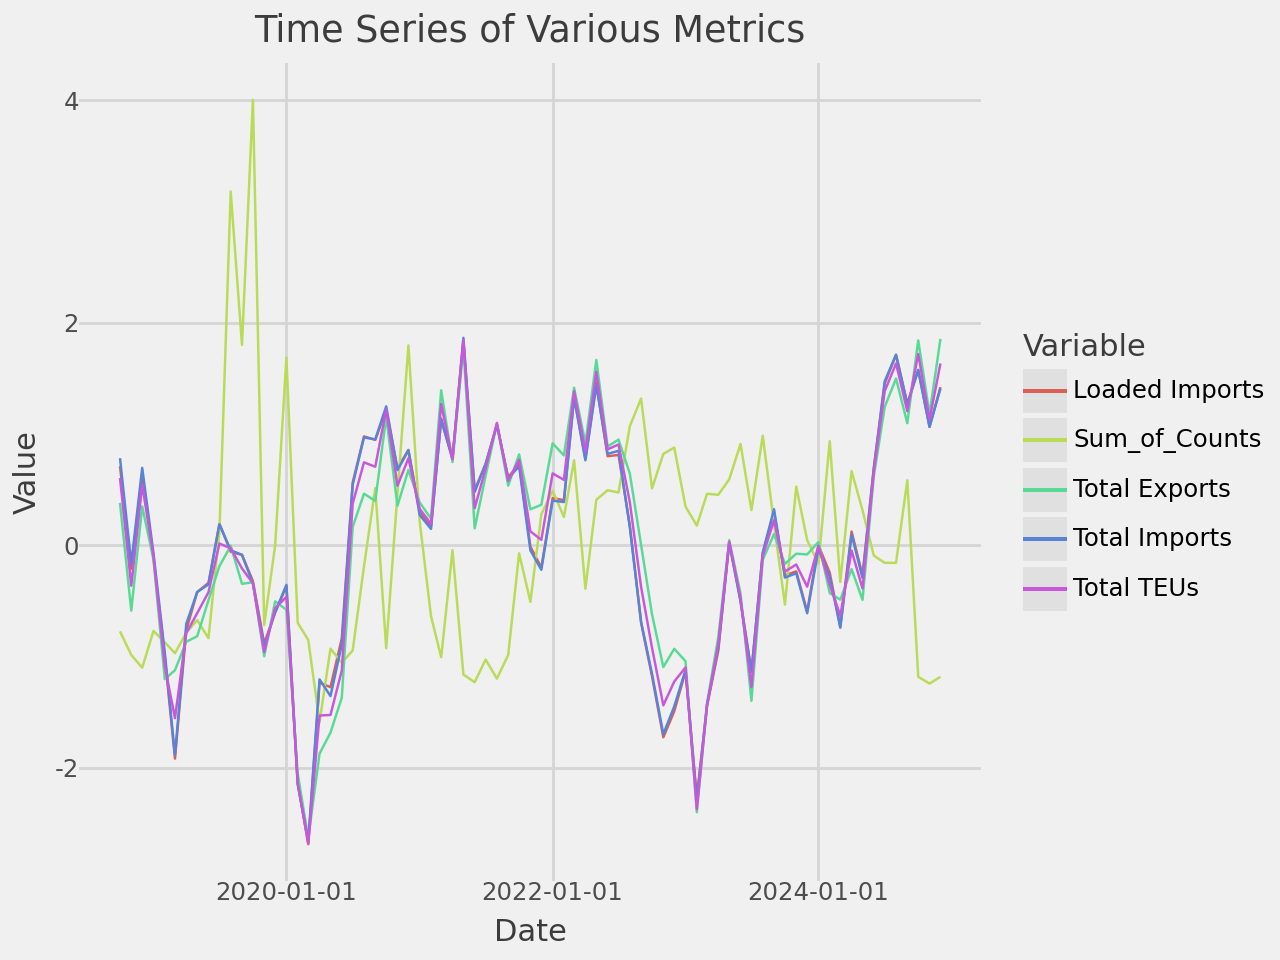

In [58]:
from plotnine import ggplot, aes, geom_line, labs, theme_minimal

# Melt the dataframe to long format for easier plotting with plotnine
GLA_data_melted = GLA_data_transformed_df.melt(id_vars=['Date'], value_vars=['Loaded Imports', 'Sum_of_Counts', 'Total Exports', 'Total Imports', 'Total TEUs'], var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(GLA_data_melted, aes(x='Date', y='Value', color='Variable'))
    + geom_line()
    + labs(title='Time Series of Various Metrics',
           x='Date',
           y='Value')
    + theme_538())

plot

A primera vista, se observa un más que probable outlier en 'Total TEUs'. Se van realizar distintas visualizaciones para esta variable: boxplot, diagrama scatter...

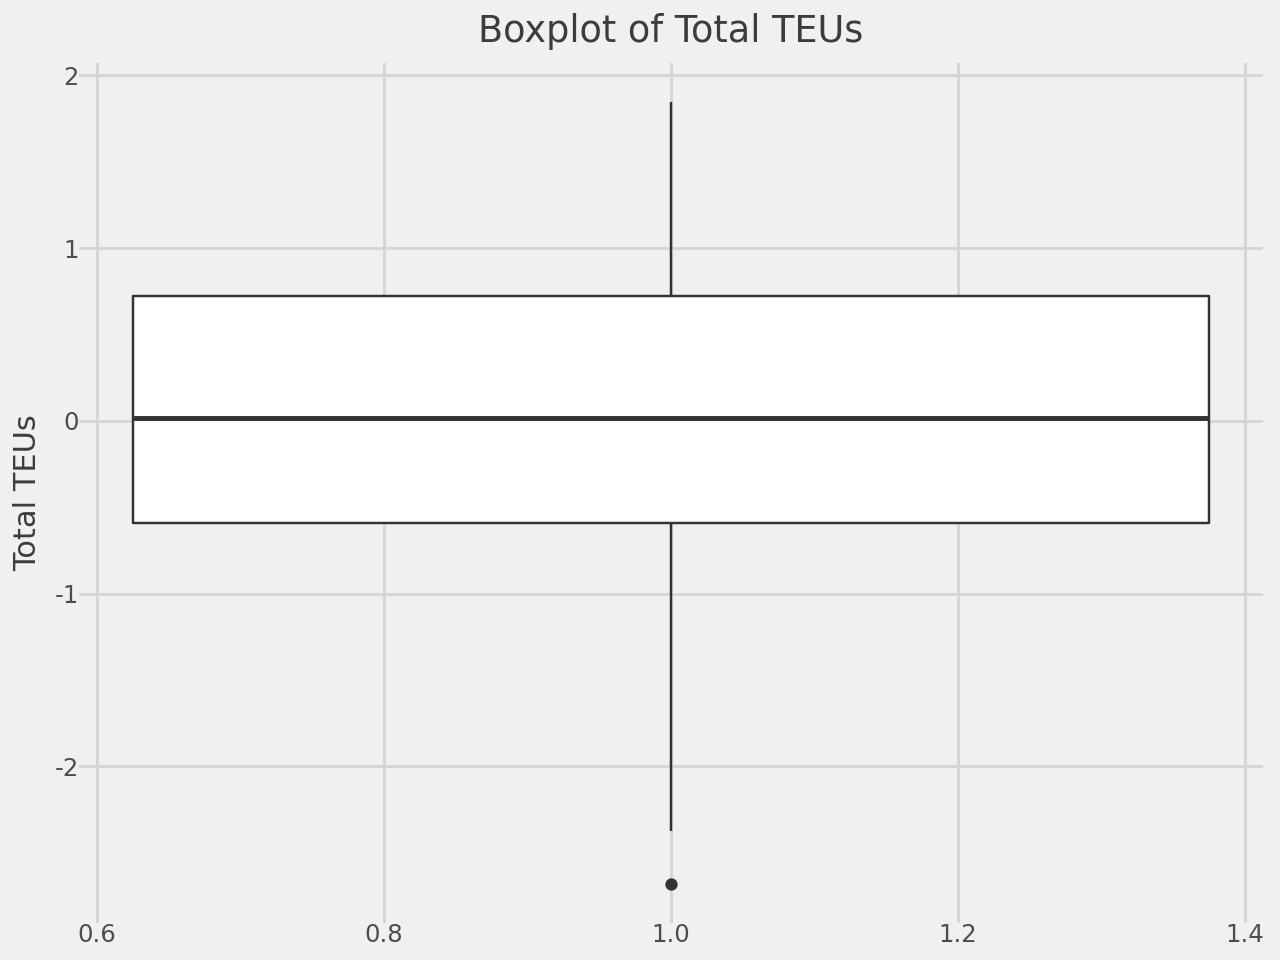

In [59]:
from plotnine import ggplot, aes, geom_boxplot, geom_point, geom_histogram, stat_qq, stat_qq_line, labs, theme_minimal

# Boxplot for 'Total TEUs'
boxplot = (ggplot(GLA_data_transformed_df, aes(x=1, y='Total TEUs'))
           + geom_boxplot()
           + labs(title='Boxplot of Total TEUs', x='', y='Total TEUs')
           + theme_538())

boxplot

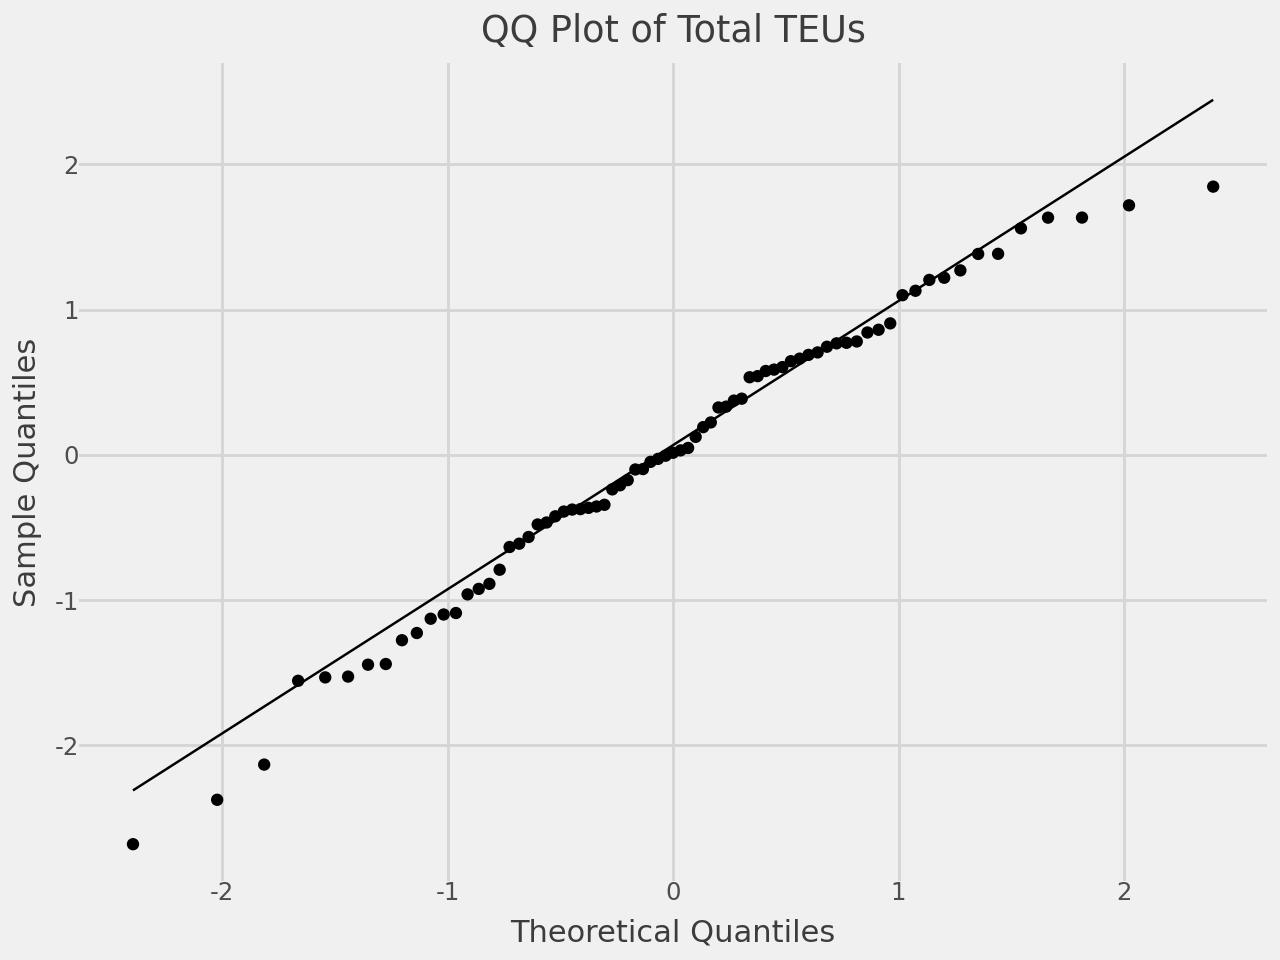

In [63]:

# QQ plot for 'Total TEUs'
qq_plot = (ggplot(GLA_data_transformed_df, aes(sample='Total TEUs'))
           + stat_qq()
           + stat_qq_line()
           + labs(title='QQ Plot of Total TEUs', x='Theoretical Quantiles', y='Sample Quantiles')
           + theme_538())

qq_plot

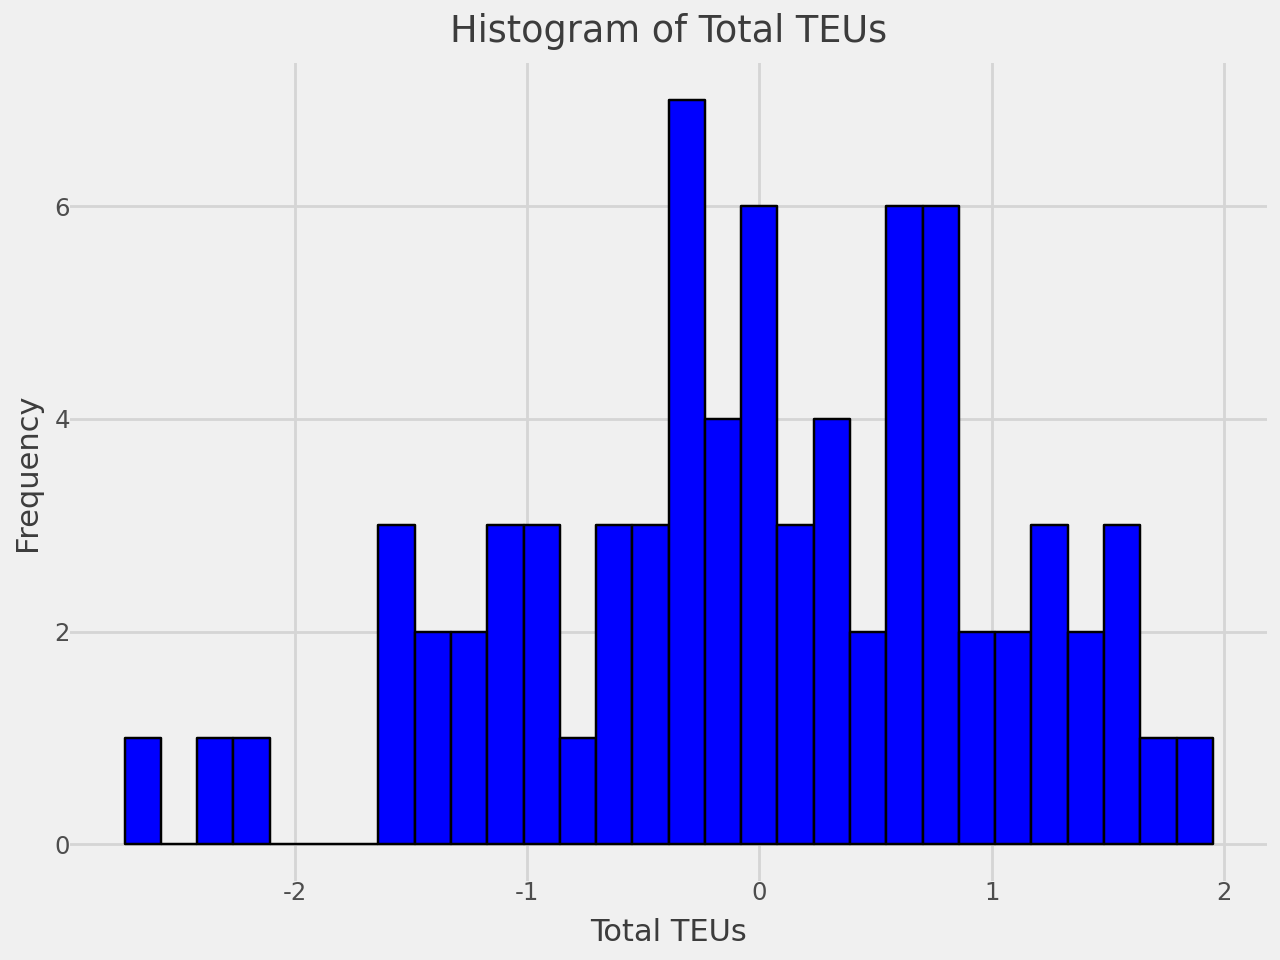

In [64]:
# Histogram for 'Total TEUs'
histogram = (ggplot(GLA_data_transformed_df, aes(x='Total TEUs'))
             + geom_histogram(bins=30, fill='blue', color='black')
             + labs(title='Histogram of Total TEUs', x='Total TEUs', y='Frequency')
             + theme_538())

histogram

Queda claro que ese valor es un outlier. ¿Pero qué hacer? ¿Cómo se ha llegado hasta él? No hay muchos datos y quizá eliminar toda esa fila de datos no fuera necesario. Así que voy a ver si originalmente existía tal dato y cómo se llegó a él.

In [44]:
# Find the index of the maximum value in 'Total TEUs'
max_teus_index = GLA_data['Total TEUs'].idxmax()

# Get the 'Date' value for this index
max_teus_date = GLA_data.loc[max_teus_index, 'Date']

# Print the index and the 'Date' value
print(f"Index: {max_teus_index}, Date: {max_teus_date}")

Index: 25, Date: 2020-11-01 00:00:00


In [45]:
GLA_data['Total Imports'].iloc[25]

861861.4

In [46]:
GLA_data['Total Exports'].iloc[25]

781408.75

In [ ]:
res = GLA_data['Total Imports'].iloc[25] + GLA_data['Total Exports'].iloc[25]
res

Se ha corroborado que (Sum Imports + Sum Exports) = TEUs Total se cumple en la mayoría de los casos.
Falla para el índice 25 (noviembre-2020) que es el dato tratado. Puesto que el resultado del dataframe resultante es la suma de los datos ofrecidos tanto por el Puerto de Los Angeles como el de Long Beach, se va acudir a las fuentes originarias para observar si el error está originado allí:
- https://www.portoflosangeles.org/business/statistics/container-statistics/historical-teu-statistics-2020:
292,762.25 	423,678.75 	889.,748.15 -> Hay un error de formato en la columna TEUs.
- Para el caso de Long Beach, el formato es correcto.

In [55]:
# Dado que ahora conocemos tanto el origen del error como el valor resultante, se va modificar el valor de 'Total TEUs' en la fila 25:
GLA_data.loc[25, 'Total TEUs'] = res


Tras arreglar ese dato, se va a proceder a tratar los outliers en el resto de variables:

In [65]:
GLA_data_transformed_df.to_csv('../sources/GreaterLosAngeles_data_transformed.csv', index=False, sep=',')

Recuperar el dataframe original, añadir columna 'Los Angeles' y sus coordenadas (es posible considerar incluir la población)

In [68]:
us_port_hubs = pd.read_csv('../sources/ais_noaa_gov/us_port_hubs.csv')
us_port_hubs.drop(columns=['Unnamed: 0'], inplace=True)

df_port_drugs = GLA_data.copy()

In [69]:
df_port_drugs['latitude'] = us_port_hubs.loc[3, 'coord_0']
df_port_drugs['longitude'] = us_port_hubs.loc[3, 'coord_1']

In [70]:
df_port_drugs

,Date,Loaded Imports,Empty Imports,Total Imports,Loaded Exports,Empty Exports,Total Exports,Total TEUs,Count of Event_Cocaine,Count of Event_Ecstasy,...,Sum Qty (lbs)_Ketamine,Sum Qty (lbs)_Khat (Catha Edulis),Sum Qty (lbs)_Lsd,Sum Qty (lbs)_Marijuana,Sum Qty (lbs)_Methamphetamine,Sum Qty (lbs)_Other Drugs**,Sum_of_Counts,Computed_Value,latitude,longitude
0,2018-10-01,849907.55,24256.30,874163.85,293660.90,490137.00,783797.90,1657961.75,7.0,32.0,...,0.010803,NaN,0.066800,127.027181,83.931240,203.496390,315.0,0.0,33.804338,-118.379055
1,2018-11-01,742669.65,22472.50,765142.15,268301.00,420721.75,689022.75,1454164.90,9.0,14.0,...,2.625265,0.022487,NaN,585.021569,131.299629,217.793147,263.0,0.0,33.804338,-118.379055
2,2018-12-01,842003.85,22145.40,864149.25,261294.40,519461.50,780755.90,1644905.15,3.0,22.0,...,0.124120,NaN,NaN,297.873352,54.976674,37.396352,235.0,0.0,33.804338,-118.379055
3,2019-01-01,753760.75,22097.75,775858.50,262281.00,471596.00,733877.00,1509735.50,8.0,22.0,...,0.086642,NaN,0.004806,433.247190,3848.539843,40.716999,316.0,0.0,33.804338,-118.379055
4,2019-02-01,651180.75,21968.80,673149.55,247841.50,380932.50,628774.00,1301923.55,4.0,21.0,...,0.050927,NaN,NaN,819.444162,37.897022,29.259156,291.0,0.0,33.804338,-118.379055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2024-08-01,966230.70,14946.60,981177.30,226389.75,666904.00,893293.75,1874470.05,16.0,30.0,...,5.350619,NaN,0.298065,2035.833714,112.703836,3216.752298,466.0,1.0,33.804338,-118.379055
71,2024-09-01,914802.05,15465.85,930267.90,202991.25,650946.25,853937.50,1784205.40,12.0,32.0,...,10.278259,NaN,0.114288,1135.496789,292.542839,11504.328822,648.0,0.0,33.804338,-118.379055
72,2024-10-01,950303.25,15158.25,965461.50,235560.75,691193.50,926754.25,1892216.75,5.0,10.0,...,169.249099,45.018394,0.125443,936.257811,140.019330,217.301583,215.0,1.0,33.804338,-118.379055
73,2024-11-01,890987.70,15544.85,906532.55,243200.00,618738.50,861938.50,1768469.05,5.0,9.0,...,2.000915,NaN,0.006614,1689.555755,226.644465,2425.976960,200.0,2.0,33.804338,-118.379055


Incluir puerto de Seattle:

Incluir puerto de San Diego:

Incluir puerto de Newark/New York:

Incluir puerto de Miami/Fort Lauderdale:

Incluir puerto de Houston: